In [1]:
import torch
import os
import random
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

torch.manual_seed(42)

import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torchvision.models import EfficientNet_B3_Weights,efficientnet_b3
from torchvision import transforms
import torchvision
from torchvision.datasets import ImageFolder
from torchinfo import summary

D:\Python Projects For Github\Chest-Cancer detector\cancer\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.__version__

'2.0.1+cu117'

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
TRAIN_DIR = './Data/train'
VAL_DIR = './Data/valid'
TEST_DIR = './Data/test'

In [5]:
labels = os.listdir(TRAIN_DIR)

In [6]:
data_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize(size=(300,300)),
    transforms.RandomAutocontrast(p=0.6),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    
])

In [7]:
train_data = ImageFolder(root=TRAIN_DIR,
                                  transform=data_transform)

test_data = ImageFolder(root=TEST_DIR,
                              transform=data_transform)
val_data = ImageFolder(root=VAL_DIR,
                              transform=data_transform)

In [8]:
train_loader = DataLoader(train_data,shuffle=True,batch_size=50)
test_loader = DataLoader(test_data,shuffle=False,batch_size=8)
valid_loader = DataLoader(val_data,shuffle=False,batch_size=1)

In [9]:
weights = EfficientNet_B3_Weights.IMAGENET1K_V1

In [10]:
effnet3 = efficientnet_b3(weights=weights)

In [11]:
for param in effnet3.parameters():
    param.requires_grad = False

In [12]:
effnet3.classifier[1] = nn.Sequential(
    nn.BatchNorm1d(num_features=1536),    
    nn.Linear(1536, 512),
    nn.ReLU(),
    nn.BatchNorm1d(num_features=512),
    nn.Linear(512,128),
    nn.ReLU(),
    nn.BatchNorm1d(num_features=128),
    nn.Dropout(0.4),
    nn.Linear(128, 4),
    )

In [13]:
summary(effnet3,input_size = [50, 3, 300, 300])

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [50, 4]                   --
├─Sequential: 1-1                                       [50, 1536, 10, 10]        --
│    └─Conv2dNormActivation: 2-1                        [50, 40, 150, 150]        --
│    │    └─Conv2d: 3-1                                 [50, 40, 150, 150]        (1,080)
│    │    └─BatchNorm2d: 3-2                            [50, 40, 150, 150]        (80)
│    │    └─SiLU: 3-3                                   [50, 40, 150, 150]        --
│    └─Sequential: 2-2                                  [50, 24, 150, 150]        --
│    │    └─MBConv: 3-4                                 [50, 24, 150, 150]        (2,298)
│    │    └─MBConv: 3-5                                 [50, 24, 150, 150]        (1,206)
│    └─Sequential: 2-3                                  [50, 32, 75, 75]          --
│    │    └─MBConv: 3-6                    

In [14]:
effnet3.to(device)
# loss function
loss_fn = nn.CrossEntropyLoss()
# Optimizer for weight adjustment
optimizer = torch.optim.Adam(effnet3.parameters(), lr = 0.001)

In [15]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X)

        # Calculate and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # Optimizer zero grad
        optimizer.zero_grad()

        # Loss backward Tracking(autograd)
        loss.backward()

        # Optimizer step(making changes to the weigths)
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [16]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager this remove grad
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # Forward pass
            test_pred_logits = model(X)

            # Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [17]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = torch.nn.CrossEntropyLoss(),
          epochs: int = 20):
    
    #Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_loader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # Print Results after each epoch
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [18]:
# Set number of epochs
NUM_EPOCHS = 30

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model
model_results = train(model=effnet3, 
                        train_dataloader=train_loader,
                        test_dataloader=test_loader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and duration of training
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  3%|██▊                                                                                | 1/30 [00:14<06:58, 14.42s/it]

Epoch: 1 | train_loss: 1.0235 | train_acc: 0.5744 | test_loss: 1.1901 | test_acc: 0.5010


  7%|█████▌                                                                             | 2/30 [00:25<05:40, 12.17s/it]

Epoch: 2 | train_loss: 0.6018 | train_acc: 0.7946 | test_loss: 0.9482 | test_acc: 0.6010


 10%|████████▎                                                                          | 3/30 [00:35<05:09, 11.45s/it]

Epoch: 3 | train_loss: 0.4649 | train_acc: 0.8381 | test_loss: 0.7792 | test_acc: 0.7073


 13%|███████████                                                                        | 4/30 [00:46<04:48, 11.10s/it]

Epoch: 4 | train_loss: 0.3849 | train_acc: 0.8625 | test_loss: 0.6993 | test_acc: 0.7323


 17%|█████████████▊                                                                     | 5/30 [00:56<04:33, 10.94s/it]

Epoch: 5 | train_loss: 0.3133 | train_acc: 0.8774 | test_loss: 0.5924 | test_acc: 0.7667


 20%|████████████████▌                                                                  | 6/30 [01:07<04:19, 10.82s/it]

Epoch: 6 | train_loss: 0.2958 | train_acc: 0.8989 | test_loss: 0.5507 | test_acc: 0.7656


 23%|███████████████████▎                                                               | 7/30 [01:18<04:07, 10.76s/it]

Epoch: 7 | train_loss: 0.2646 | train_acc: 0.9025 | test_loss: 0.4720 | test_acc: 0.8073


 27%|██████████████████████▏                                                            | 8/30 [01:28<03:55, 10.70s/it]

Epoch: 8 | train_loss: 0.2197 | train_acc: 0.9354 | test_loss: 0.5091 | test_acc: 0.8073


 30%|████████████████████████▉                                                          | 9/30 [01:39<03:43, 10.66s/it]

Epoch: 9 | train_loss: 0.2829 | train_acc: 0.9084 | test_loss: 0.4672 | test_acc: 0.8250


 33%|███████████████████████████▎                                                      | 10/30 [01:49<03:33, 10.69s/it]

Epoch: 10 | train_loss: 0.2149 | train_acc: 0.9295 | test_loss: 0.4760 | test_acc: 0.8198


 37%|██████████████████████████████                                                    | 11/30 [02:00<03:23, 10.73s/it]

Epoch: 11 | train_loss: 0.2270 | train_acc: 0.9253 | test_loss: 0.4572 | test_acc: 0.8438


 40%|████████████████████████████████▊                                                 | 12/30 [02:11<03:13, 10.74s/it]

Epoch: 12 | train_loss: 0.2337 | train_acc: 0.9194 | test_loss: 0.4406 | test_acc: 0.8354


 43%|███████████████████████████████████▌                                              | 13/30 [02:22<03:01, 10.70s/it]

Epoch: 13 | train_loss: 0.1919 | train_acc: 0.9238 | test_loss: 0.4765 | test_acc: 0.8375


 47%|██████████████████████████████████████▎                                           | 14/30 [02:32<02:50, 10.67s/it]

Epoch: 14 | train_loss: 0.1559 | train_acc: 0.9451 | test_loss: 0.4538 | test_acc: 0.8125


 50%|█████████████████████████████████████████                                         | 15/30 [02:43<02:39, 10.65s/it]

Epoch: 15 | train_loss: 0.1704 | train_acc: 0.9315 | test_loss: 0.4236 | test_acc: 0.8562


 53%|███████████████████████████████████████████▋                                      | 16/30 [02:53<02:28, 10.63s/it]

Epoch: 16 | train_loss: 0.1570 | train_acc: 0.9359 | test_loss: 0.4239 | test_acc: 0.8375


 57%|██████████████████████████████████████████████▍                                   | 17/30 [03:04<02:17, 10.60s/it]

Epoch: 17 | train_loss: 0.1711 | train_acc: 0.9464 | test_loss: 0.4138 | test_acc: 0.8625


 60%|█████████████████████████████████████████████████▏                                | 18/30 [03:15<02:07, 10.62s/it]

Epoch: 18 | train_loss: 0.1755 | train_acc: 0.9369 | test_loss: 0.4606 | test_acc: 0.8500


 63%|███████████████████████████████████████████████████▉                              | 19/30 [03:25<01:56, 10.61s/it]

Epoch: 19 | train_loss: 0.1693 | train_acc: 0.9325 | test_loss: 0.5206 | test_acc: 0.8219


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [03:36<01:46, 10.62s/it]

Epoch: 20 | train_loss: 0.1574 | train_acc: 0.9510 | test_loss: 0.4544 | test_acc: 0.8292


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [03:47<01:35, 10.62s/it]

Epoch: 21 | train_loss: 0.1588 | train_acc: 0.9446 | test_loss: 0.4122 | test_acc: 0.8510


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [03:57<01:25, 10.63s/it]

Epoch: 22 | train_loss: 0.1227 | train_acc: 0.9677 | test_loss: 0.3971 | test_acc: 0.8719


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [04:08<01:15, 10.74s/it]

Epoch: 23 | train_loss: 0.1433 | train_acc: 0.9528 | test_loss: 0.4428 | test_acc: 0.8510


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [04:19<01:05, 10.83s/it]

Epoch: 24 | train_loss: 0.1669 | train_acc: 0.9451 | test_loss: 0.4394 | test_acc: 0.8469


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [04:30<00:53, 10.79s/it]

Epoch: 25 | train_loss: 0.1332 | train_acc: 0.9572 | test_loss: 0.5122 | test_acc: 0.8250


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [04:40<00:42, 10.74s/it]

Epoch: 26 | train_loss: 0.1496 | train_acc: 0.9525 | test_loss: 0.4609 | test_acc: 0.8562


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [04:51<00:32, 10.69s/it]

Epoch: 27 | train_loss: 0.1200 | train_acc: 0.9587 | test_loss: 0.4255 | test_acc: 0.8573


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [05:02<00:21, 10.66s/it]

Epoch: 28 | train_loss: 0.1149 | train_acc: 0.9679 | test_loss: 0.4592 | test_acc: 0.8260


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [05:12<00:10, 10.67s/it]

Epoch: 29 | train_loss: 0.1336 | train_acc: 0.9615 | test_loss: 0.4620 | test_acc: 0.8094


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [05:23<00:00, 10.78s/it]

Epoch: 30 | train_loss: 0.1532 | train_acc: 0.9400 | test_loss: 0.4127 | test_acc: 0.8812
Total training time: 323.540 seconds


In [19]:
def accuracy_of_model(model,loader,loss_fn):
    # Put model in eval mode
    model.eval()
    val_loss = 0
    val_acc = 0
    
    with torch.inference_mode():
        for batch,(data,target) in enumerate(loader):
            data,target = data.to(device),target.to(device)

            # make prediction
            pred = model(data)
            
            # calculate loss
            loss = loss_fn(pred,target)
            val_loss = loss.item()
            
            # calculate accuracy
            pred_label = torch.argmax(torch.softmax(pred,dim=1),dim=1)
            val_acc += ((pred_label == target).sum().item()/len(pred_label))
    val_loss = val_loss / len(loader)
    val_acc = val_acc / len(loader)
    return val_acc,val_loss

In [39]:
accuracy,loss = accuracy_of_model(effnet3,valid_loader,loss_fn)
print(f'Accuracy of EfficientNetB3 model(validation): {accuracy*100}')
print(f'Loss of EfficientnetB3 model(validation): {loss}')

Accuracy of EfficientNetB3 model(validation): 86.11111111111111
Loss of EfficientnetB3 model(validation): 5.524448351934552e-05


In [26]:
classes = train_data.classes

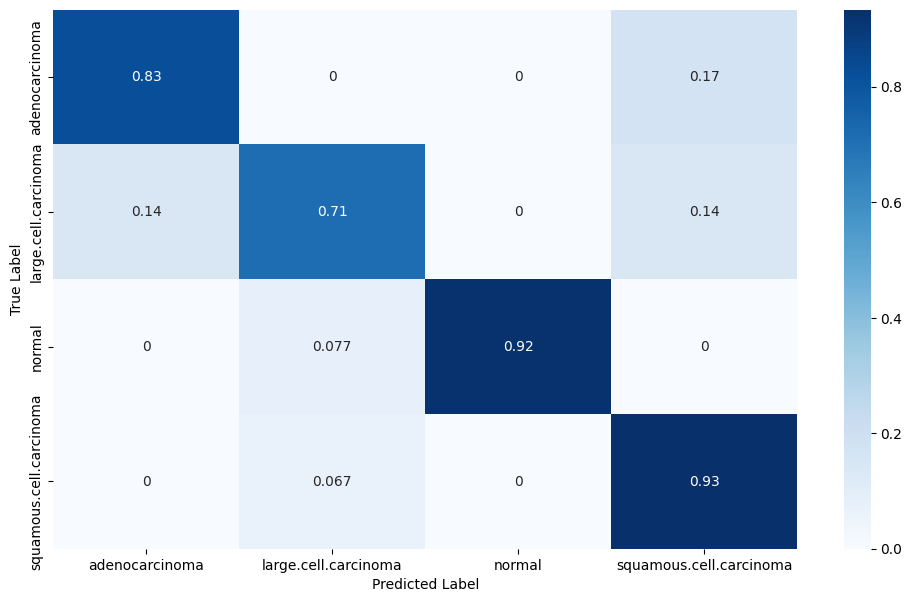

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

effnet3.eval()
# iterate over test data
with torch.inference_mode():
    for batch,(inputs, labels) in enumerate(valid_loader):
        
        inputs, labels = inputs.to(device),labels.to(device)
        output = effnet3(inputs) # Feed Network

        output = torch.argmax(output, dim=1).cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
s = sns.heatmap(df_cm, annot=True,cmap="Blues")
s.set(xlabel='Predicted Label', ylabel='True Label')
plt.savefig('cmatrixEfficientNetB3.png')

In [34]:
torch.save(effnet3.state_dict(),'./BestModel/EfficientNetB3_cancer.pth')